In [1]:
#import libraries
import pandas as pd
import plotly.express as px
import numpy as np

#load dataset
df = pd.read_csv("/Users/bsama/Downloads/beckdel_allinfo_final.csv")
df.head()

,year,rating,imdbid,id,title,imdb_tt,genre,description,imdb_rating,bechdel_pass
0,1874,0,3155794,9602,Passage de Venus,tt3155794,"Documentary, Short, History",Early chronophotography of the 1874 Venus tran...,6.8,No
1,1877,0,14495706,9804,La Rosace Magique,tt14495706,"Animation, Short",Pre-cinematography color animation of Abstract...,5.7,No
2,1878,0,2221420,9603,Sallie Gardner at a Gallop,tt2221420,"Documentary, Short, Sport","The clip shows a jockey, Gilbert Domm, riding ...",7.3,No
3,1878,0,12592084,9806,Le singe musicien,tt12592084,"Animation, Short",Pre-cinematograph colour animation of the monk...,6.0,No
4,1881,0,7816420,9816,Athlete Swinging a Pick,tt7816420,"Documentary, Short","In this brief photographic sequence, Eadweard ...",5.1,No


In [2]:
df1 = df.drop(['imdbid','id','imdb_tt','description'],axis='columns')    #drop unwanted features
df1.head()

,year,rating,title,genre,imdb_rating,bechdel_pass
0,1874,0,Passage de Venus,"Documentary, Short, History",6.8,No
1,1877,0,La Rosace Magique,"Animation, Short",5.7,No
2,1878,0,Sallie Gardner at a Gallop,"Documentary, Short, Sport",7.3,No
3,1878,0,Le singe musicien,"Animation, Short",6.0,No
4,1881,0,Athlete Swinging a Pick,"Documentary, Short",5.1,No


In [6]:
df2 = df1.dropna()     #drop null values
df2.isnull().sum()

year            0
rating          0
title           0
genre           0
imdb_rating     0
bechdel_pass    0
dtype: int64

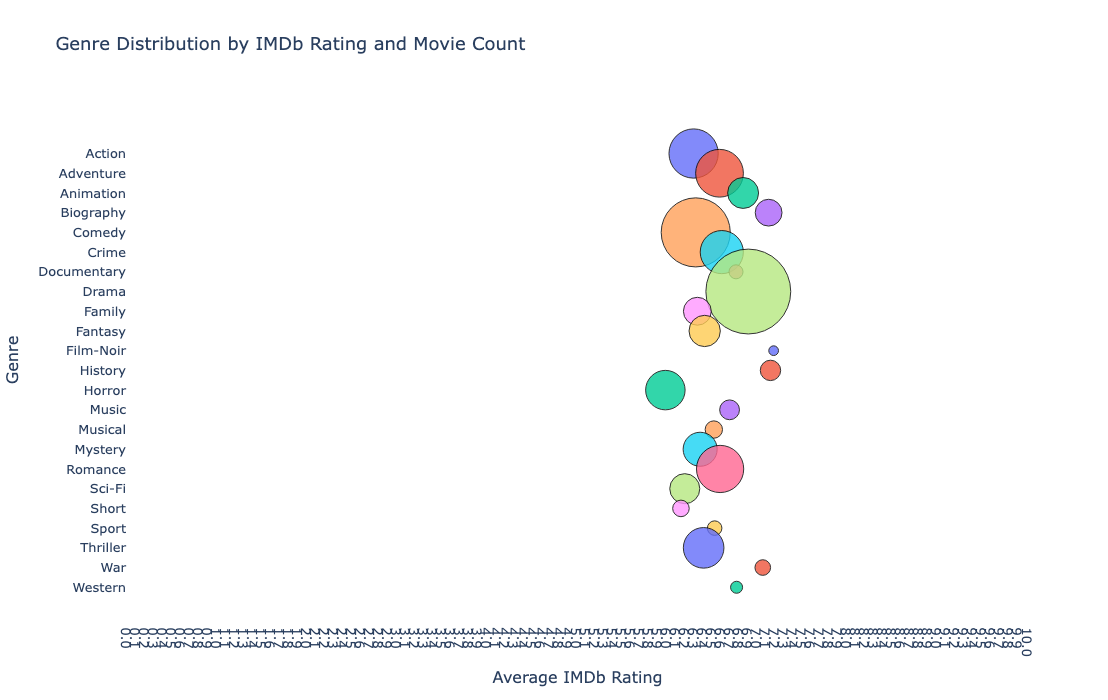

In [44]:
# preparing Data
df_bubble2= df2.copy()

# split multi-genre rows
df_bubble2["genre"] = df_bubble2["genre"].str.split(",")
df_bubble2 = df_bubble2.explode("genre")
df_bubble2["genre"] = df_bubble2["genre"].str.strip()

# group by genre
genre_stats = (
    df_bubble2.groupby("genre")
    .agg(
        count=("imdb_rating", "size"),
        avg_rating=("imdb_rating", "mean")
    )
    .reset_index()
)

# removing small genres
genre_stats = genre_stats[genre_stats["count"] >= 5]

# add horizontal jitter
np.random.seed(42)
genre_stats["x_jitter"] = genre_stats["avg_rating"] + np.random.uniform(
    -0.15, 0.15, len(genre_stats)
)

# bubble plot
fig = px.scatter(
    genre_stats,
    x="x_jitter",
    y="genre",
    size="count",
    color="genre",   # categorical colors (one per genre)
    size_max=60,
    title="Genre Distribution by IMDb Rating and Movie Count",
    labels={
        "x_jitter": "Average IMDb Rating",
        "genre": "Genre",
        "count": "Number of Movies"
    },
    hover_data={
        "avg_rating": ":.2f",
        "count": True,
        "genre": True
    }
)

# styling
fig.update_layout(
    height=700,
    paper_bgcolor="white",
    plot_bgcolor="white",
    font=dict(size=13),
    showlegend=False  # hide legend if too cluttered (many genres)
)

fig.update_xaxes(
    range=[0, 10],
    dtick=0.1,          # shows 6.1, 6.2, 6.3, etc.
    tickformat=".1f"   # force one decimal place
)

fig.update_traces(marker=dict(opacity=0.8, line=dict(width=1, color="black")))

fig.show()

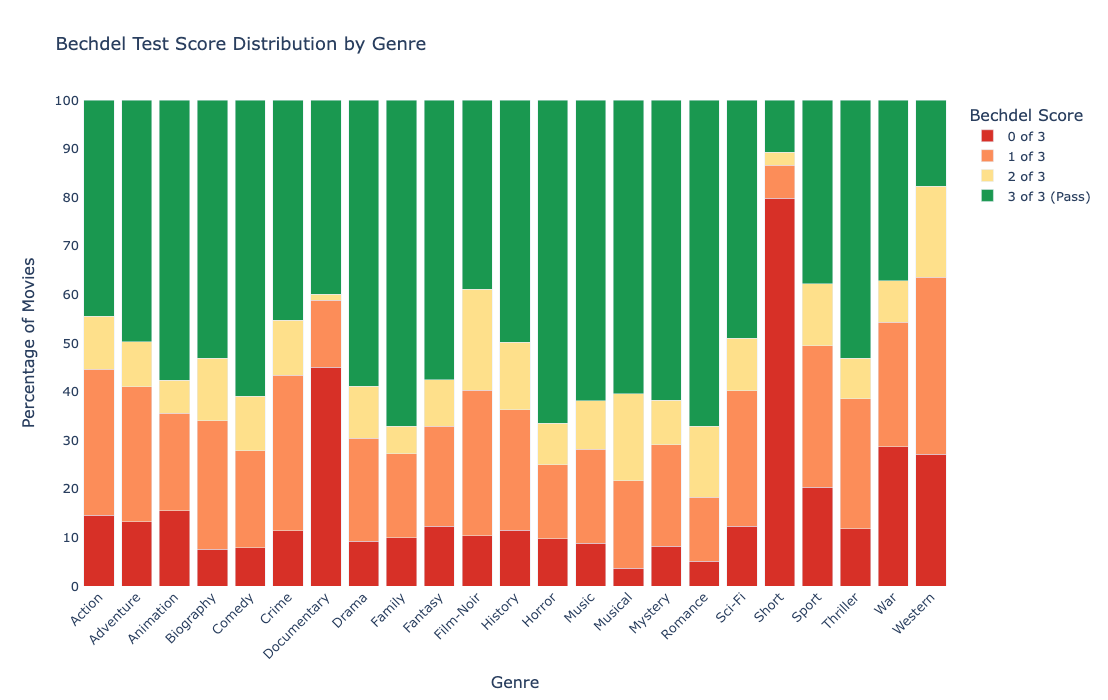

In [27]:

# prepare data
df_bar2 = df2.copy()

# split multi-genre rows
df_bar2["genre_list"] = df_bar2["genre"].str.split(",")
df_bar2 = df_bar2.explode("genre_list")
df_bar2["genre_list"] = df_bar2["genre_list"].str.strip()

# keep only valid bechdel scores
df_bar2 = df_bar2[df_bar2["rating"].isin([0, 1, 2, 3])]

# remove unwanted genres (too less number of datapoints)
df_bar = df_bar[~df_bar["genre_list"].isin(["Adult", "News"])]

# count movies per genre per score
counts = (
    df_bar.groupby(["genre_list", "rating"])
    .size()
    .reset_index(name="count")
)

# convert to percentages per genre
counts["percentage"] = (
    counts.groupby("genre_list")["count"]
    .transform(lambda x: 100 * x / x.sum())
)

# label mapping
rating_labels = {
    0: "0 of 3",
    1: "1 of 3",
    2: "2 of 3",
    3: "3 of 3 (Pass)"
}
counts["label"] = counts["rating"].map(rating_labels)

# order genres by percentage passing
pass_order = (
    counts[counts["rating"] == 3]
    .sort_values("percentage", ascending=False)["genre_list"]
)

counts["genre_list"] = pd.Categorical(
    counts["genre_list"],
    categories=pass_order,
    ordered=True
)

# plot
fig = px.bar(
    counts,
    x="genre_list",
    y="percentage",
    color="label",
    title=f"Bechdel Test Score Distribution by Genre",
    labels={
        "genre_list": "Genre",
        "percentage": "Percentage of Movies",
        "label": "Bechdel Score"
    },
    category_orders={
        "label": ["0 of 3", "1 of 3", "2 of 3", "3 of 3 (Pass)"]
    },
    color_discrete_map={
        "0 of 3": "#d73027",
        "1 of 3": "#fc8d59",
        "2 of 3": "#fee08b",
        "3 of 3 (Pass)": "#1a9850"
    }
)

# making it 100% stacked
fig.update_layout(
    barmode="stack",
    height=700,
    paper_bgcolor="white",
    plot_bgcolor="white",
    font=dict(size=13),
    xaxis_tickangle=-45
)

fig.update_yaxes(range=[0, 100], dtick=10)

fig.show()

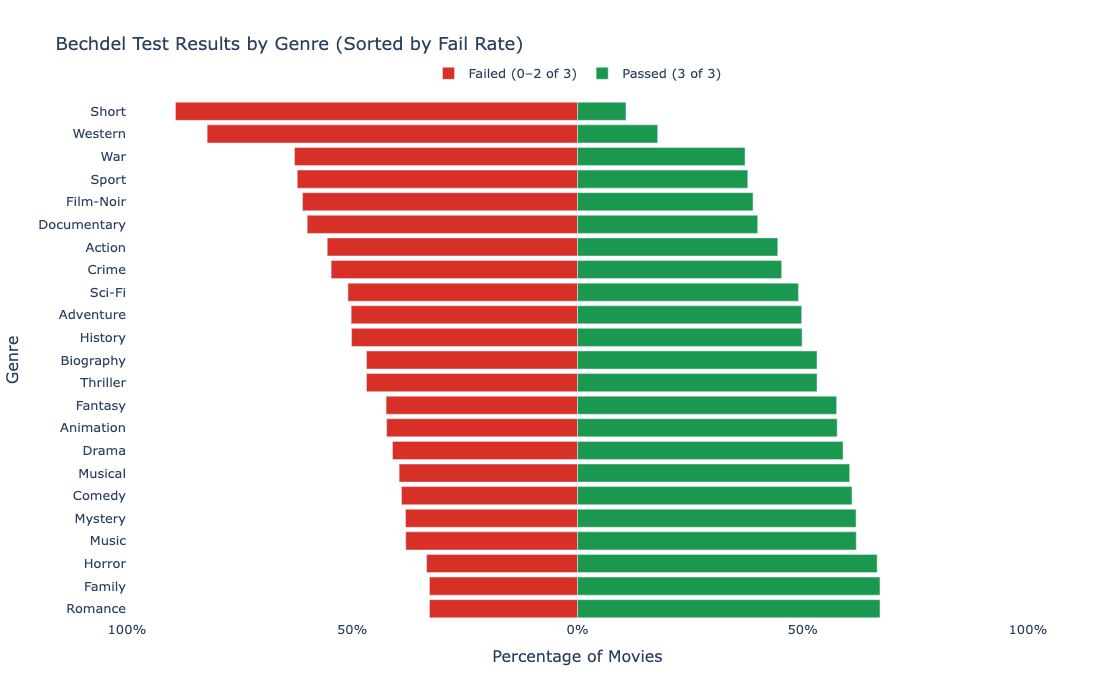

In [45]:
import plotly.graph_objects as go

df_bar = df2.copy()

# split multi-genre rows
df_bar["genre_list"] = df_bar["genre"].str.split(",")
df_bar = df_bar.explode("genre_list")
df_bar["genre_list"] = df_bar["genre_list"].str.strip()

# keep valid Bechdel ratings
df_bar = df_bar[df_bar["rating"].isin([0, 1, 2, 3])]

# remove unwanted genres (too less number of datapoints)
df_bar = df_bar[~df_bar["genre_list"].isin(["Adult", "News"])]

# compute pass/fail percentages
grouped = df_bar.groupby("genre_list")

summary = grouped.agg(
    total=("rating", "count"),
    pass_count=("rating", lambda x: (x == 3).sum()),
    fail_count=("rating", lambda x: (x != 3).sum())
).reset_index()

summary["pass_pct"] = 100 * summary["pass_count"] / summary["total"]
summary["fail_pct"] = 100 * summary["fail_count"] / summary["total"]

# sort by fail rate ascending
summary = summary.sort_values("fail_pct", ascending=True)

# build diverging bar chart
fig = go.Figure()

# fail (left, negative values)
fig.add_bar(
    y=summary["genre_list"],
    x=-summary["fail_pct"],
    orientation="h",
    name="Failed (0–2 of 3)",
    marker_color="#d73027",
    hovertemplate="Genre: %{y}<br>Fail: %{x:.1f}%<extra></extra>"
)

# pass (right, positive values)
fig.add_bar(
    y=summary["genre_list"],
    x=summary["pass_pct"],
    orientation="h",
    name="Passed (3 of 3)",
    marker_color="#1a9850",
    hovertemplate="Genre: %{y}<br>Pass: %{x:.1f}%<extra></extra>"
)

# styling
fig.update_layout(
    title="Bechdel Test Results by Genre (Sorted by Fail Rate)",
    barmode="relative",
    height=700,
    paper_bgcolor="white",
    plot_bgcolor="white",
    xaxis_title="Percentage of Movies",
    yaxis_title="Genre",
    font=dict(size=13),
    legend=dict(orientation="h", y=1.08, x=0.5, xanchor="center")
)

# centered percentage axis
fig.update_xaxes(
    tickvals=[-100, -50, 0, 50, 100],
    ticktext=["100%", "50%", "0%", "50%", "100%"],
    range=[-100, 100]
)

fig.show()

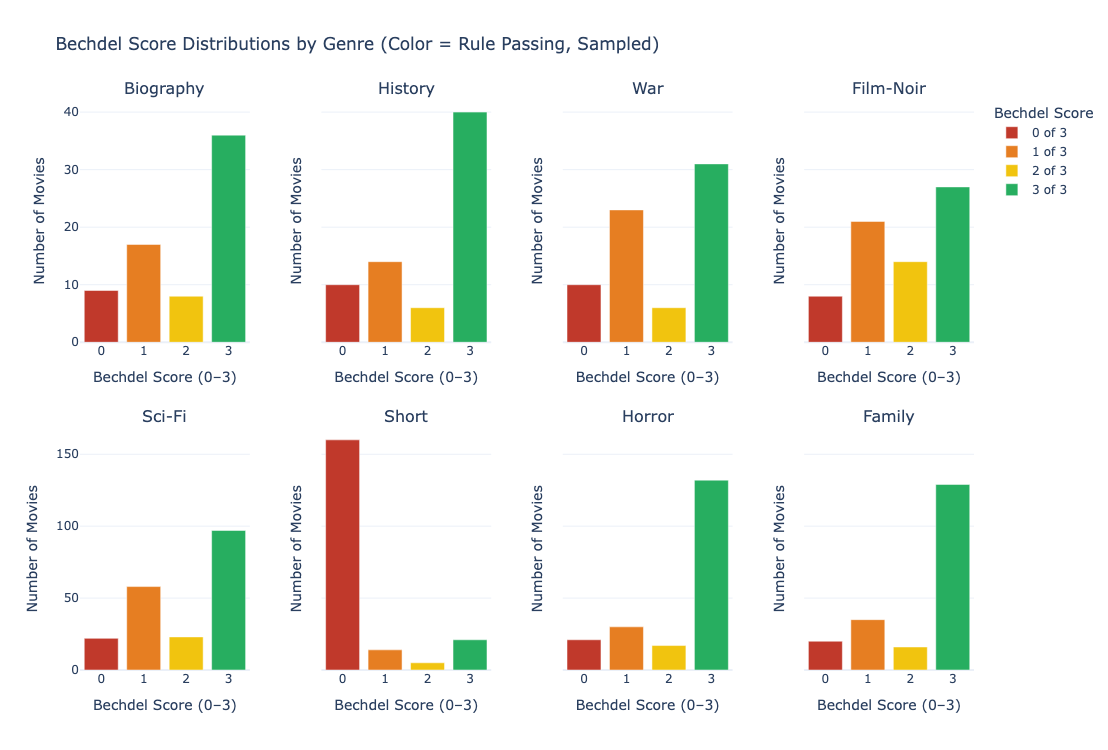

In [46]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# initialising
RIGHT_GENRES = ["Biography", "History", "War", "Film-Noir"]
LEFT_GENRES = ["Sci-Fi", "Short", "Horror", "Family"]
ALL_GENRES = RIGHT_GENRES + LEFT_GENRES

SAMPLE_MAP = {
    "Biography": 70,
    "History": 70,
    "War": 70,
    "Film-Noir": 70,
    "Sci-Fi": 200,
    "Short": 200,
    "Horror": 200,
    "Family": 200
}

SCORES = [0, 1, 2, 3]

# bechdel color scheme
SCORE_COLORS = {
    0: "#C0392B",  # red
    1: "#E67E22",  # orange
    2: "#F1C40F",  # yellow
    3: "#27AE60"   # green
}

# data prep
df = df2.copy()

df["bechdel_score"] = pd.to_numeric(df["rating"], errors="coerce")

# split multi-genre movies
df["genre"] = df["genre"].str.split(", ")
df = df.explode("genre")

df = df[df["genre"].isin(ALL_GENRES)]

# subplot layout
fig = make_subplots(
    rows=2,
    cols=4,
    subplot_titles=ALL_GENRES,
    shared_yaxes=True,
    horizontal_spacing=0.08,
    vertical_spacing=0.15
)

# building mini charts
for i, genre in enumerate(ALL_GENRES):
    r = 1 if i < 4 else 2
    c = i + 1 if i < 4 else i - 3

    gdata = df[df["genre"] == genre]

    n_sample = SAMPLE_MAP[genre]
    if len(gdata) > n_sample:
        gdata = gdata.sample(n_sample, random_state=42)

    counts = (
        gdata["bechdel_score"]
        .value_counts()
        .reindex(SCORES, fill_value=0)
        .sort_index()
    )

    # adding one bar trace per score to colour individually
    for score in SCORES:
        fig.add_trace(
            go.Bar(
                x=[score],
                y=[counts.loc[score]],
                marker_color=SCORE_COLORS[score],
                showlegend=(i == 0),
                name=f"{score} of 3"
            ),
            row=r,
            col=c
        )

# styling
fig.update_layout(
    title="Bechdel Score Distributions by Genre (Color = Rule Passing, Sampled)",
    template="plotly_white",
    height=750,
    legend_title_text="Bechdel Score"
)

fig.update_xaxes(
    title_text="Bechdel Score (0–3)",
    tickmode="array",
    tickvals=SCORES
)

fig.update_yaxes(
    title_text="Number of Movies"
)

fig.show()
